# Exploratory Data Analysis of Weather in Illinois

In [1]:
import pandas as pd # DataFrame library
import numpy as np # Array library
import matplotlib.pyplot as plt # Plotting library
import folium # Geographical map library
from folium.plugins import MarkerCluster # Allows multiple markers to be created at once without slowing down the rendering of the map
import os

### The data was extracted from the NOAA's Global Historical Climatology Network (GHCN) dataset. The SQL query was run in the Google BigQuery console as shown below. The resulting dataset was saved to a dataframe as shown in the next cell.

![Illinois Temperature Data (1990 - 2023).png](<attachment:Illinois Temperature Data (1990 - 2023).png>)

In [2]:
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = "./secrets/my_credentials.json" # Credentials to be able to access the Google BigQuery public datasets

In [3]:
raw_weather_query = """SELECT weather.id, weather.date, weather.time, weather.element, weather.value,
                       stations.latitude, stations.longitude, stations.name 
                       FROM `bigquery-public-data.ghcn_d.ghcnd_*` AS weather
                       INNER JOIN `bigquery-public-data.ghcn_d.ghcnd_stations` AS stations
                       ON weather.id = stations.id
                       WHERE weather.id LIKE 'US%'
                       AND weather.element IN ('TMAX', 'TMIN', 'TOBS')
                       AND weather.qflag IS NULL
                       AND EXTRACT(YEAR FROM weather.date) BETWEEN 1990 AND 2023
                       AND weather._TABLE_SUFFIX BETWEEN '1990' AND '2023'
                       AND stations.id LIKE 'US%'
                       AND stations.state = 'IL'; """ # This query extracts weather data from the US in Illinois from the year 1990 to 2023
raw_weather_data = pd.read_gbq(raw_weather_query, use_bqstorage_api = True, progress_bar_type = "tqdm_notebook", dialect = "standard") # Load the data from the SQL query through Google BigQuery

Downloading:   0%|          |

### The cell below loads a subset of the data that's needed for analysis along with some modifications to the "time" column.

In [4]:
desired_cols = ["id", "date", "time", "name", "element", "value", "latitude", "longitude"] # columns that are going to be used for analysis
desired_types = {"id": "string", 
                 "date": "string", 
                 "time": "string", 
                 "name": "string", 
                 "element": "string", 
                 "value": "float", 
                 "latitude": "float", 
                 "longitude": "float"} # the data types that will be assigned per column
raw_weather_data = raw_weather_data.astype(desired_types) # assign the appropriate data types for each column
raw_weather_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4741298 entries, 0 to 4741297
Data columns (total 8 columns):
 #   Column     Dtype  
---  ------     -----  
 0   id         string 
 1   date       string 
 2   time       string 
 3   element    string 
 4   value      float64
 5   latitude   float64
 6   longitude  float64
 7   name       string 
dtypes: float64(3), string(5)
memory usage: 289.4 MB


In [5]:
raw_weather_data["time"].fillna("0000", inplace = True) # replace all nan values with "0000"

### The function below fixes the length of the time values which are in string form so that they have a fixed length of 4 characters.

In [6]:
np.sort(raw_weather_data["time"].apply(len).unique()) # helps to verify how many unique length characters there was in the "time" column. 
# there should only be one of length 4 characters to be able to parse into datetime format.

array([4])

In [7]:
raw_weather_data["time"] = raw_weather_data["time"].apply(lambda x: f"{x[:-2]}:{x[-2:]}:00") # added a seconds placeholder for parsing
raw_weather_data["time"] = pd.to_timedelta(raw_weather_data["time"]) # converts string format to datetime format

In [8]:
raw_weather_data["date"] = pd.to_datetime(raw_weather_data["date"]) # converts the string format to a datetime format
raw_weather_data["date"] = raw_weather_data["date"] + raw_weather_data["time"] # combines date and time into the same column which can be accessed via object attributes
raw_weather_data.drop(columns = ["time"], inplace = True) # drops the redundant time column
raw_weather_data

,id,date,element,value,latitude,longitude,name
0,USC00118389,2020-06-19 07:00:00,TMAX,317.0,39.5608,-88.6089,SULLIVAN 3S
1,USC00110356,2020-06-19 07:00:00,TMIN,150.0,40.6633,-90.4447,AVON
2,USC00116344,2020-06-24 00:00:00,TOBS,139.0,40.1100,-87.9567,OGDEN
3,USC00110356,2020-06-25 07:00:00,TMAX,261.0,40.6633,-90.4447,AVON
4,USC00118389,2020-06-27 07:00:00,TMIN,239.0,39.5608,-88.6089,SULLIVAN 3S
...,...,...,...,...,...,...,...
4741293,USC00112745,2016-10-27 07:00:00,TOBS,61.0,42.3161,-90.2269,ELIZABETH
4741294,USC00112745,2016-05-04 07:00:00,TMAX,200.0,42.3161,-90.2269,ELIZABETH
4741295,USC00112745,2016-08-17 07:00:00,TMIN,172.0,42.3161,-90.2269,ELIZABETH
4741296,USC00112745,2016-08-18 07:00:00,TMIN,200.0,42.3161,-90.2269,ELIZABETH


### The cell below pivots the element values into columns which are more useful in column format.

In [9]:
raw_weather_pivot = raw_weather_data.pivot(columns = "element", values = "value")
raw_weather_pivot

element,TMAX,TMIN,TOBS
0,317.0,NaN,NaN
1,NaN,150.0,NaN
2,NaN,NaN,139.0
3,261.0,NaN,NaN
4,NaN,239.0,NaN
...,...,...,...
4741293,NaN,NaN,61.0
4741294,200.0,NaN,NaN
4741295,NaN,172.0,NaN
4741296,NaN,200.0,NaN


In [10]:
transformed_data = pd.concat([raw_weather_data, raw_weather_pivot], axis = 1) # combine the newly generated columns with the existing dataframe
transformed_data.drop(columns = ["element", "value"], inplace = True) # drop the element and value columns
transformed_data["TMIN"] = 9/5 * (transformed_data["TMIN"] / 10) + 32 # converting from tenths of a degree Celsius to Fahrenheit
transformed_data["TMAX"] = 9/5 * (transformed_data["TMAX"] / 10) + 32 
transformed_data["TOBS"] = 9/5 * (transformed_data["TOBS"] / 10) + 32
transformed_data

,id,date,latitude,longitude,name,TMAX,TMIN,TOBS
0,USC00118389,2020-06-19 07:00:00,39.5608,-88.6089,SULLIVAN 3S,89.06,NaN,NaN
1,USC00110356,2020-06-19 07:00:00,40.6633,-90.4447,AVON,NaN,59.00,NaN
2,USC00116344,2020-06-24 00:00:00,40.1100,-87.9567,OGDEN,NaN,NaN,57.02
3,USC00110356,2020-06-25 07:00:00,40.6633,-90.4447,AVON,78.98,NaN,NaN
4,USC00118389,2020-06-27 07:00:00,39.5608,-88.6089,SULLIVAN 3S,NaN,75.02,NaN
...,...,...,...,...,...,...,...,...
4741293,USC00112745,2016-10-27 07:00:00,42.3161,-90.2269,ELIZABETH,NaN,NaN,42.98
4741294,USC00112745,2016-05-04 07:00:00,42.3161,-90.2269,ELIZABETH,68.00,NaN,NaN
4741295,USC00112745,2016-08-17 07:00:00,42.3161,-90.2269,ELIZABETH,NaN,62.96,NaN
4741296,USC00112745,2016-08-18 07:00:00,42.3161,-90.2269,ELIZABETH,NaN,68.00,NaN


### This cell below plots the minimum, maximum, and observed temperatures.

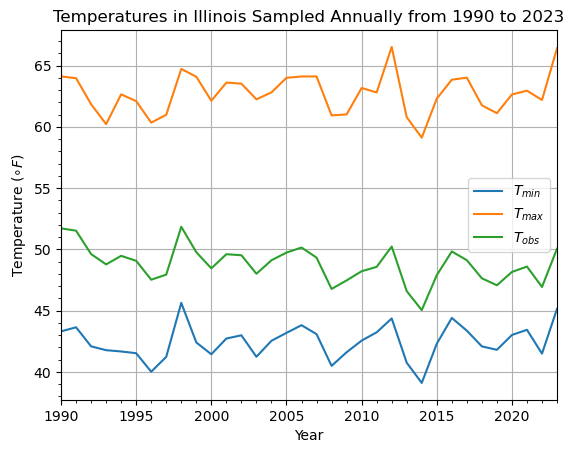

In [11]:
# Resample the temperature data annually and calculate the mean
numeric_data = transformed_data.select_dtypes(include = ["datetime64[ns]", "float"])
resampled_data = numeric_data.resample("Y", on="date").mean()
resampled_data.index = pd.to_datetime(resampled_data.index)
tmin_label = r"$T_{min}$"
tmax_label = r"$T_{max}$"
tobs_label = r"$T_{obs}$"

# Plotting TMIN, TMAX, and TOBS
plt.plot(resampled_data.index.year, resampled_data["TMIN"], label= tmin_label)
plt.plot(resampled_data.index.year, resampled_data["TMAX"], label= tmax_label)
plt.plot(resampled_data.index.year, resampled_data["TOBS"], label= tobs_label)

# Set labels and title
plt.xlabel("Year")
plt.ylabel(r"Temperature ($\circ F$)")
plt.title("Temperatures in Illinois Sampled Annually from 1990 to 2023")

# Display the legend
plt.legend(loc="best")

# Fixes the x-range so that it's between 1990 and 2023
plt.xlim(resampled_data.index.year.min(), resampled_data.index.year.max())

# Display the grid
plt.grid()

# Display minor ticks
plt.minorticks_on()

# Show the plot
plt.show()

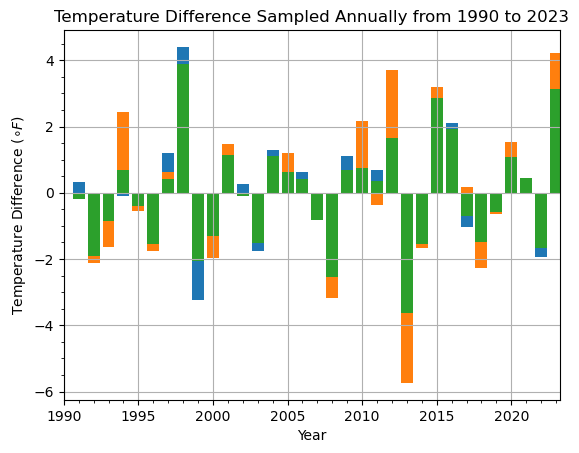

In [12]:
# Plotting the temperature gradient (difference) for TMIN, TMAX, TOBS
plt.bar(resampled_data.index.year, resampled_data["TMIN"].diff(), label = tmin_label)
plt.bar(resampled_data.index.year, resampled_data["TMAX"].diff(), label = tmax_label)
plt.bar(resampled_data.index.year, resampled_data["TOBS"].diff(), label = tobs_label)

# Adding labels
plt.xlabel("Year")
plt.ylabel(r"Temperature Difference ($\circ F$)")

# Fix the x-range so that all the bars for each year display properly
plt.xlim(resampled_data.index.year.min(), resampled_data.index.year.max() + 0.25)

# Adding a title
plt.title("Temperature Difference Sampled Annually from 1990 to 2023")

# Display grid and minor ticks
plt.grid()

plt.minorticks_on()

# Show the plot
plt.show()

In [13]:
count_query = """SELECT COUNT(DISTINCT weather.id)
                 FROM `bigquery-public-data.ghcn_d.ghcnd_*` AS weather
                 INNER JOIN `bigquery-public-data.ghcn_d.ghcnd_stations` AS stations
                 ON weather.id = stations.id
                 WHERE weather.id LIKE 'US%'
                 AND EXTRACT(YEAR FROM weather.date) BETWEEN 1990 AND 2023
                 AND weather._TABLE_SUFFIX BETWEEN '1990' AND '2023'
                 AND stations.id LIKE 'US%'
                 AND stations.state = 'IL'; """
total_number_of_stations = pd.read_gbq(count_query).iloc[0,0]
total_number_of_stations

1927

In [14]:
transformed_data["name"].nunique() # number of stations in Illinois with respect to TMIN, TMAX, TOBS

209

In [15]:
f"{transformed_data["name"].nunique() / total_number_of_stations * 100:.2f}% of stations are temperature measurements."

'10.85% of stations are temperature measurements.'

In [23]:
num_obs_per_station = transformed_data.groupby("name", as_index = False)["date"].count() # number of observations per station w.r.t. TMIN, TMAX, TOBS
num_obs_per_station.rename(columns = {"date": "obs_count"}, inplace = True)
num_obs_per_station

,name,obs_count
0,ALBION,15352
1,ALEDO,35761
2,ALTON - MELVIN PRICE L&D,31602
3,ALTONA,17872
4,ANNA 4 N,25714
...,...,...
204,WAUKEGAN,12384
205,WHEATON 3 SE,22074
206,WHITE HALL 1 E,36514
207,WINCHESTER,17375


In [24]:
num_obs_per_station.describe()

,obs_count
count,209.000000
mean,22685.636364
std,11375.888388
min,1.000000
25%,14156.000000
50%,24173.000000
75%,33674.000000
max,37155.000000


In [30]:
stations_in_between_quantiles = (num_obs_per_station["obs_count"] > num_obs_per_station["obs_count"].quantile(0.25)) & (num_obs_per_station["obs_count"] < num_obs_per_station["obs_count"].quantile(0.75))
num_obs_per_station[stations_in_between_quantiles]

,name,obs_count
0,ALBION,15352
2,ALTON - MELVIN PRICE L&D,31602
3,ALTONA,17872
4,ANNA 4 N,25714
5,ANTIOCH,17156
...,...,...
198,VANDALIA,24391
200,VIRDEN,22900
203,WATSEKA 2NW,31809
205,WHEATON 3 SE,22074


In [17]:
num_obs_per_station.min() # Station with the least number of observations w.r.t. TMIN, TMAX, TOBS

/var/folders/j5/byfswq3j1bg3s3yk6x9qdzbr0000gp/T/ipykernel_5215/2289167633.py:1: FutureWarning: <class 'pandas.core.arrays.string_.StringArray'>._reduce will require a `keepdims` parameter in the future
  num_obs_per_station.min() # Station with the least number of observations w.r.t. TMIN, TMAX, TOBS


name         ALBION
obs_count         1
dtype: object

In [18]:
num_obs_per_station.max() # Station with the most number of observations w.r.t. TMIN, TMAX, TOBS

/var/folders/j5/byfswq3j1bg3s3yk6x9qdzbr0000gp/T/ipykernel_5215/2916560759.py:1: FutureWarning: <class 'pandas.core.arrays.string_.StringArray'>._reduce will require a `keepdims` parameter in the future
  num_obs_per_station.max() # Station with the most number of observations w.r.t. TMIN, TMAX, TOBS


name         WINDSOR
obs_count      37155
dtype: object

In [19]:
def map_of_temps_for_each_year(df, year):
    """Generates a map for each year this will be updated to generate a slider bar or dropdown menu

    Args:
        df (pandas.DataFrame): the dataset that will be plotted on the map
        year (int): the year for which to filter the dataset and put markers for
    """
    year_data = df[df["date"].dt.year == year]
    # Create a base map
    my_map = folium.Map(location = [year_data["latitude"].dropna().mean(), year_data["longitude"].dropna().mean()], zoom_start = 100)

    # Create marker cluster
    marker_cluster = MarkerCluster().add_to(my_map)

    # Add markers for each data point
    for index, row in year_data.iterrows():
        folium.Marker([row["latitude"], row["longitude"]], 
                     popup = f"Temperature: {row["TOBS"]:.0f}°F",
                     tooltip = f"Station Name: {row["name"]}").add_to(marker_cluster)
    my_map.save(f"{year} Temperature Map.html")

In [20]:
map_of_temps_for_each_year(transformed_data, 1990)